# IMDB classification with MLPs and CNNs

The dataset is originally from http://ai.stanford.edu/~amaas/data/sentiment/

Code based on 
https://github.com/fchollet/keras/blob/master/examples/pretrained_word_embeddings.py

Here's our plan:

* load the dataset
* Keep only the most frequently occuring 20000 words
* Pad or truncate all reviews to fixed length (300)
* Look up an embedding for each word
* Build our networks: a simple MLP and then a 1D CNN

In [1]:
from __future__ import print_function

import os
import os.path
import sys
import numpy as np
import cPickle as pickle
import matplotlib.pyplot as plt
import seaborn as sns

In [82]:
from keras.datasets import imdb
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Dense, Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, Embedding, LSTM
from keras.models import Sequential, Model
from keras.preprocessing.text import Tokenizer

In [32]:
from display import visualize_keras_model, plot_training_curves

In [3]:
%matplotlib inline
sns.set_style('white')
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

In [4]:
# To work around bug in latest version of the dataset in Keras,
# load older version manually, downloaded from 
# https://s3.amazonaws.com/text-datasets/imdb_full.pkl
print('Loading data...')
path = os.path.expanduser('~/.keras/datasets/imdb_full.pkl')
f = open(path, 'rb')
(x_train, y_train), (x_test, y_test) = pickle.load(f)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

Loading data...
25000 train sequences
25000 test sequences


In [5]:
word2index = imdb.get_word_index()

In [6]:
# we want the other direction
index2word = dict([(i,w) for (w,i) in word2index.items()])

In [7]:
def totext(review):
    return ' '.join(index2word[i] for i in review)

In [9]:
GLOVE_DIR = os.path.expanduser('~/data/glove')
MAX_SEQUENCE_LENGTH = 300
MAX_NB_WORDS = 20000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2

In [10]:
# first, build index mapping words in the embeddings set
# to their embedding vector

print('Indexing word vectors.')

embeddings_index = {} # word -> coefs
# We'll use the 100-dimensional version
with open(os.path.join(GLOVE_DIR, 'glove.6B.100d.txt')) as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

print('Found %s word vectors.' % len(embeddings_index))

Indexing word vectors.
Found 400000 word vectors.


In [11]:
# Shuffle training and test data
# (copying from imdb.py because we had to load data manually)
seed = 113
np.random.seed(seed)
np.random.shuffle(x_train)
np.random.seed(seed) # same shuffle for labels!
np.random.shuffle(y_train)

np.random.seed(seed * 2)
np.random.shuffle(x_test)
np.random.seed(seed * 2)
np.random.shuffle(y_test)

In [13]:
print('Pad sequences')
x_train = pad_sequences(x_train, maxlen=MAX_SEQUENCE_LENGTH)
x_test = pad_sequences(x_test, maxlen=MAX_SEQUENCE_LENGTH)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

Pad sequences
x_train shape: (25000, 300)
x_test shape: (25000, 300)


In [14]:
# Recall: words are indexed in descending order of frequency. Remove the 
# less frequent ones -- replace with constant value
x_train[x_train >= MAX_NB_WORDS] = MAX_NB_WORDS-1
x_test[x_test >= MAX_NB_WORDS] = MAX_NB_WORDS-1

In [15]:
print('Preparing embedding matrix.')

# prepare embedding matrix
num_words = min(MAX_NB_WORDS, len(word2index))
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word2index.items():
    if i >= MAX_NB_WORDS:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

# load pre-trained word embeddings into an Embedding layer
# note that we set trainable = False so as to keep the embeddings fixed
embedding_layer = Embedding(num_words,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

Preparing embedding matrix.


# MLP

Let's try a simple two-layer dense network, based on the embeddings...

In [72]:
# train a regular MLP
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='float32')
embedded_sequences = embedding_layer(sequence_input)
x = Flatten()(embedded_sequences)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
preds = Dense(1, activation='sigmoid')(x)

model_mlp = Model(sequence_input, preds)
model_mlp.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

In [73]:
model_mlp.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        (None, 300)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 300, 100)          2000000   
_________________________________________________________________
flatten_7 (Flatten)          (None, 30000)             0         
_________________________________________________________________
dense_27 (Dense)             (None, 256)               7680256   
_________________________________________________________________
dropout_6 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_28 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 257       
Total para

In [75]:
print('Training model.')
history = model_mlp.fit(x_train, y_train, validation_data=(x_test, y_test),
          epochs=25, batch_size=128)

Training model.
Train on 25000 samples, validate on 25000 samples
Epoch 1/25
25000/25000 [==============================] - 46s - loss: 0.6791 - acc: 0.5932 - val_loss: 0.6450 - val_acc: 0.6370
Epoch 2/25
25000/25000 [==============================] - 46s - loss: 0.6162 - acc: 0.6568 - val_loss: 0.6020 - val_acc: 0.6690
Epoch 3/25
25000/25000 [==============================] - 47s - loss: 0.5699 - acc: 0.6976 - val_loss: 0.5575 - val_acc: 0.7260
Epoch 4/25
25000/25000 [==============================] - 47s - loss: 0.5334 - acc: 0.7247 - val_loss: 0.7564 - val_acc: 0.6234
Epoch 5/25
25000/25000 [==============================] - 47s - loss: 0.4937 - acc: 0.7499 - val_loss: 0.5565 - val_acc: 0.7216
Epoch 6/25
25000/25000 [==============================] - 46s - loss: 0.4539 - acc: 0.7766 - val_loss: 0.5664 - val_acc: 0.7245
Epoch 7/25
25000/25000 [==============================] - 42s - loss: 0.4225 - acc: 0.7924 - val_loss: 0.6253 - val_acc: 0.7342
Epoch 8/25
25000/25000 [==============

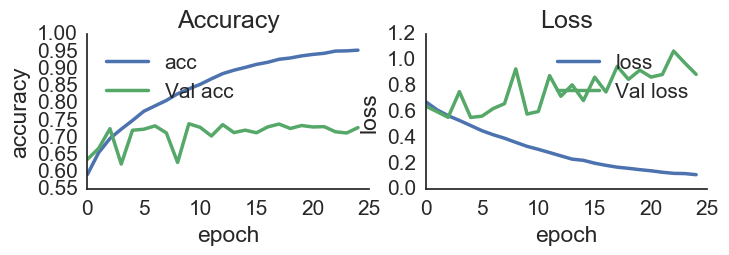

In [77]:
plot_training_curves(history.history);

In [81]:
score, acc = model_mlp.evaluate(x_test, y_test,
                            batch_size=128)
print('Test score:', score)
print('Test accuracy:', acc)

24960/25000 [============================>.] - ETA: 0sTest score: 0.890198716736
Test accuracy: 0.729199999962


Overfitting! In practice, would use the weights after ~5 epochs. Get 70% accuracy. Let's see if we can do better with a CNN...

# 1D CNN

It's not a crazy assumption that adjacent words are more important than far away ones, and that the same groups of words in different positions mean roughly the same thing, so we can use our CNN tricks. Sequences are 1D, so we'll use a 1-D sliding window of weights.

In [38]:
# train a 1D convnet with global maxpooling
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
x = Conv1D(128, 5, activation='relu')(embedded_sequences)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = MaxPooling1D(7)(x)  # modified from example since our seq len is 300 
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
preds = Dense(1, activation='sigmoid')(x)

model = Model(sequence_input, preds)
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

In [39]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 300)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 300, 100)          2000000   
_________________________________________________________________
conv1d_25 (Conv1D)           (None, 296, 128)          64128     
_________________________________________________________________
max_pooling1d_22 (MaxPooling (None, 59, 128)           0         
_________________________________________________________________
conv1d_26 (Conv1D)           (None, 55, 128)           82048     
_________________________________________________________________
max_pooling1d_23 (MaxPooling (None, 11, 128)           0         
_________________________________________________________________
conv1d_27 (Conv1D)           (None, 7, 128)            82048     
__________

In [40]:
print('Training model.')
history = model.fit(x_train, y_train, validation_data=(x_test, y_test),
          epochs=10, batch_size=128)

Training model.
Train on 25000 samples, validate on 25000 samples
Epoch 1/10
25000/25000 [==============================] - 78s - loss: 0.5911 - acc: 0.6814 - val_loss: 0.5472 - val_acc: 0.7362
Epoch 2/10
25000/25000 [==============================] - 78s - loss: 0.4484 - acc: 0.7970 - val_loss: 0.3987 - val_acc: 0.8168
Epoch 3/10
25000/25000 [==============================] - 78s - loss: 0.3992 - acc: 0.8235 - val_loss: 0.6086 - val_acc: 0.7018
Epoch 4/10
25000/25000 [==============================] - 76s - loss: 0.3614 - acc: 0.8424 - val_loss: 0.3474 - val_acc: 0.8494
Epoch 5/10
25000/25000 [==============================] - 77s - loss: 0.3245 - acc: 0.8599 - val_loss: 0.4183 - val_acc: 0.8120
Epoch 6/10
25000/25000 [==============================] - 77s - loss: 0.2889 - acc: 0.8784 - val_loss: 0.5135 - val_acc: 0.7538
Epoch 7/10
25000/25000 [==============================] - 80s - loss: 0.2570 - acc: 0.8942 - val_loss: 0.5595 - val_acc: 0.7968
Epoch 8/10
25000/25000 [==============

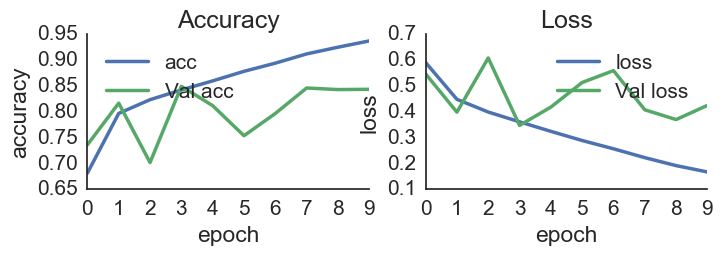

In [41]:
plot_training_curves(history.history);

In [80]:
score, acc = model.evaluate(x_test, y_test,
                            batch_size=128)
print('Test score:', score)
print('Test accuracy:', acc)

25000/25000 [==============================] - 25s    
Test score: 0.425013681984
Test accuracy: 0.843600000019


Still overfitting on the training data, but looks like we have about 84% validation accuracy. Not too bad for a first attempt.

# LSTM
Just for fun -- dataset isn't really big enough. Using fchollet's parameters..

In [ ]:
print('Build model...')
batch_size = 32
maxlen = 80

x_train_short = pad_sequences(x_train, maxlen=maxlen)
x_test_short = pad_sequences(x_train, maxlen=maxlen)

model_lstm = Sequential()
model_lstm.add(Embedding(MAX_NB_WORDS, 128))
model_lstm.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model_lstm.add(Dense(1, activation='sigmoid'))

# try using different optimizers and different optimizer configs
model_lstm.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print('Train...')
model_lstm.fit(x_train_short, y_train, batch_size=batch_size, epochs=15,
          validation_data=(x_test_short, y_test))

In [84]:
score, acc = model_lstm.evaluate(x_test_short, y_test,
                            batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

25000/25000 [==============================] - 34s    
Test score: 3.83098610489
Test accuracy: 0.5068


Perhaps due to different data prep because of the imdb.py bug, this didn't work at all... That's part of the fun of neural networks. To try:

* completely remove low frequency words from training data before training network. That way the 80 words we do keep will have more signal. (Can check how much it matters).
* try the example unchanged, using older version of TF/Keras.